In [19]:
import random
import tensorflow as tf
import numpy as np
from tensorflow.keras import Input, layers, Model, utils, initializers, losses, optimizers, Sequential, callbacks, backend
import pickle
import tensorflow.keras as K
from sklearn.metrics import recall_score as recall
from sklearn.metrics import confusion_matrix as confusion

# Custom Layers

In [2]:
class CustomAttention(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        self.hidden_size = kwargs.pop('hidden_size')
        super(CustomAttention, self).__init__(*args, **kwargs)
        self.W_omega = tf.Variable(
            initializers.GlorotNormal(seed=0)(shape=[self.hidden_size, 1]), 
            dtype=tf.float32,
            trainable=True,
            name="W_omega")
        self.b_omega = tf.Variable(
            initializers.GlorotNormal(seed=0)(shape=[1]), 
            dtype=tf.float32,
            trainable=True,
            name="b_omega")
        self.u_omega = tf.Variable(
            initializers.GlorotNormal(seed=0)(shape=[1]), 
            dtype=tf.float32,
            trainable=True,
            name="u_omega")
    
    def call(self, inputs, **kwargs):
        v = tf.sigmoid(tf.tensordot(inputs, self.W_omega, axes=1) + self.b_omega)
        vu = tf.tensordot(v, self.u_omega, axes=1)
        alphas = layers.Softmax()(vu)
        return tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)
        
    def get_config(self):
        #config = super().get_config().copy()
        config = ({
            'hidden_size': self.hidden_size 
        })
        base_config = super(CustomAttention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        #return config

In [3]:
class CenterLossLayer(tf.keras.layers.Layer):

    def __init__(self, alpha=0.5, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(4, 64),
                                       initializer='uniform',
                                       trainable=False)
        # self.counter = self.add_weight(name='counter',
        #                                shape=(1,),
        #                                initializer='zeros',
        #                                trainable=False)  # just for debugging
        super().build(input_shape)

    def call(self, x, mask=None):
        #print(x[0].shape)
        #print(x[1].shape)
        # x[0] is Nx2, x[1] is Nx10 onehot, self.centers is 10x2
        delta_centers = K.backend.dot(K.backend.transpose(x[1]), (K.backend.dot(x[1], self.centers) - x[0]))  # 10x2
        center_counts = K.backend.sum(K.backend.transpose(x[1]), axis=1, keepdims=True) + 1  # 10x1
        delta_centers /= center_counts
        new_centers = self.centers - self.alpha * delta_centers
        self.add_update((self.centers, new_centers), x)

        # self.add_update((self.counter, self.counter + 1), x)

        self.result = x[0] - K.backend.dot(x[1], self.centers)
        self.result = K.backend.sum(self.result ** 2, axis=1, keepdims=True) #/ K.dot(x[1], center_counts)
        return self.result # Nx1

    def compute_output_shape(self, input_shape):
        return K.backend.int_shape(self.result)
      
    def get_config(self):
        #config = super().get_config().copy()
        base_config = super(CenterLossLayer, self).get_config()
        return dict(list(base_config.items()))

In [4]:
def zero_loss(y_true, y_pred):
    return 0.5 * K.backend.sum(y_pred, axis=0)

In [5]:
cols_to_keep = [
        'pcm_LOGenergy_sma_range', 'pcm_LOGenergy_sma_minameandist',
       'pcm_LOGenergy_sma_linregc2', 'pcm_LOGenergy_sma_linregerrQ',
       'pcm_LOGenergy_sma_variance', 'pcm_LOGenergy_sma_quartile1',
       'pcm_LOGenergy_sma_quartile2', 'pcm_LOGenergy_sma_quartile3',
       'pcm_LOGenergy_sma_percentile95.0', 'pcm_LOGenergy_sma_percentile98.0',
       'pcm_LOGenergy_sma_peakMean', 'pcm_zcr_sma_quartile1',
       'pcm_zcr_sma_quartile2', 'pcm_zcr_sma_iqr1-2',
       'voiceProb_sma_quartile2', 'pcm_LOGenergy_sma_de_linregc2',
       'pcm_LOGenergy_sma_de_quartile1', 'pcm_LOGenergy_sma_de_quartile2',
       'pcm_LOGenergy_sma_de_percentile95.0', 'pcm_LOGenergy_sma_de_zcr',
       'pcm_LOGenergy_sma_de_peakMeanMeanDist', 'pcm_LOGenergy_sma_de_amean',
       'pcm_LOGenergy_sma_de_absmean', 'pcm_zcr_sma_de_iqr1-3',
       'voiceProb_sma_de_quartile2', 'voiceProb_sma_de_meanPeakDist',
       'F0env_sma_de_skewness', 'pcm_LOGenergy_sma_de_de_qregc1',
       'pcm_LOGenergy_sma_de_de_kurtosis', 'pcm_LOGenergy_sma_de_de_zcr'
]

# Model

In [6]:
input_shape_spec = (300, 40, 3)
input_shape_td = (300, len(cols_to_keep))
aux_input = Input(shape=(4,), name='labels')
model_input_spec = Input(shape=input_shape_spec, name='log_mel_data')
model_input_td = Input(shape=input_shape_td, name='td_data')

Convolution Layers

In [7]:
no_of_dilated_layers = 4

x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                  bias_initializer=tf.constant_initializer(0.1),
                  kernel_initializer=initializers.GlorotNormal(seed=0),
                  padding='SAME', name='traditional_cnn')(model_input_spec)
# x = layers.BatchNormalization(momentum=0.9, )(x)
x = layers.LeakyReLU(0.01)(x)
x = layers.MaxPooling2D((2, 4), strides=(2, 4), padding='VALID')(x)

conv_layer_output = x

In [8]:
for i in range(no_of_dilated_layers - 1):
    x = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                      bias_initializer=tf.constant_initializer(0.1),
                      kernel_initializer=initializers.GlorotNormal(seed=0),
                      dilation_rate=(2, 2), padding='SAME', name='dilated_cnn_uflb_'+str(i+1))(x)
    # x = CustomDilatedCNN(input_units=x.shape[-1], output_units=x.shape[-1])(x)
    x = layers.BatchNormalization(momentum=0.9, name='batch_normalization_uflb_'+str(i+1))(x)
    x = layers.LeakyReLU(0.01, name='leaky_relu_uflb_'+str(i+1))(x)

In [9]:
skip_layer_output = layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1),
                      bias_initializer=tf.constant_initializer(0.1),
                      kernel_initializer=initializers.GlorotNormal(seed=0),
                      dilation_rate=(2, 2), padding='SAME', 
                      name='dilated_cnn_skip_path')(conv_layer_output)
skip_layer_output = layers.BatchNormalization(momentum=0.9, 
                      name='batch_normalization_skip_path')(skip_layer_output)

In [10]:
x = layers.Add(name='skip_connection')([x, skip_layer_output])

Reshaping

In [11]:
# output_linear_units = 768
time_step = x.shape[1]
linear_units = x.shape[2]*x.shape[3]
x = tf.reshape(x,[-1,time_step,linear_units])
# x = tf.reshape(x, [-1, linear_units])

In [12]:
# x = layers.Dense(linear_units, activation = 'linear')(x)

Leaky Relu

In [13]:
# x = layers.BatchNormalization(momentum=0.9, )(x)
x = layers.LeakyReLU(alpha=0.01)(x)
# x = tf.reshape(x, [-1, time_step, linear_units])

BiLSTM Layer

In [14]:
x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)

Attention Layer

In [15]:
x = CustomAttention(hidden_size=x.shape[2])(x)

Fully Connected Layer and Softmax

In [16]:
x = layers.Dense(128, activation="linear")(x)
x = layers.LeakyReLU(alpha=0.01)(x)
x = layers.Dense(64, activation="linear")(x)
x = layers.LeakyReLU(alpha=0.01)(x)
model_spec = Model(inputs=model_input_spec, outputs=x, name="model_spec") 


y = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(model_input_td)
y = CustomAttention(hidden_size=y.shape[2])(y)
y = layers.Dense(128, activation="linear")(y)
y = layers.LeakyReLU(alpha=0.01)(y)
y = layers.Dense(64, activation="linear")(y)
y = layers.LeakyReLU(alpha=0.01)(y)
model_td = Model(inputs=model_input_td, outputs=y, name="model_td")

In [20]:
embed = tf.concat([model_td.output, model_spec.output], axis=1)
output = layers.Dense(128, activation="linear")(embed)
output = layers.LeakyReLU(alpha=0.01)(output)
output = layers.Dense(64, activation="linear")(output)
fully_output = layers.LeakyReLU(alpha=0.01)(output)
output = layers.Dense(4, activation="linear")(fully_output)
center_loss = CenterLossLayer(alpha=0.5, name='centerlosslayer')([fully_output, aux_input])

Compile Model

In [21]:
model = Model(inputs=[model_spec.input, model_td.input, aux_input], outputs=[output, center_loss], name="adrnn_with_td_model") 
model.compile(
    loss=[losses.CategoricalCrossentropy(from_logits=True), zero_loss],
    loss_weights = [1, 0.01],
    # optimizer=optimizers.RMSprop(
    #     learning_rate=0.00001, momentum=0.9, clipnorm=5),
    optimizer=optimizers.Adam(
        learning_rate=0.00001
    ),
    metrics=['categorical_accuracy'],
)

Display Model's Functional Graph

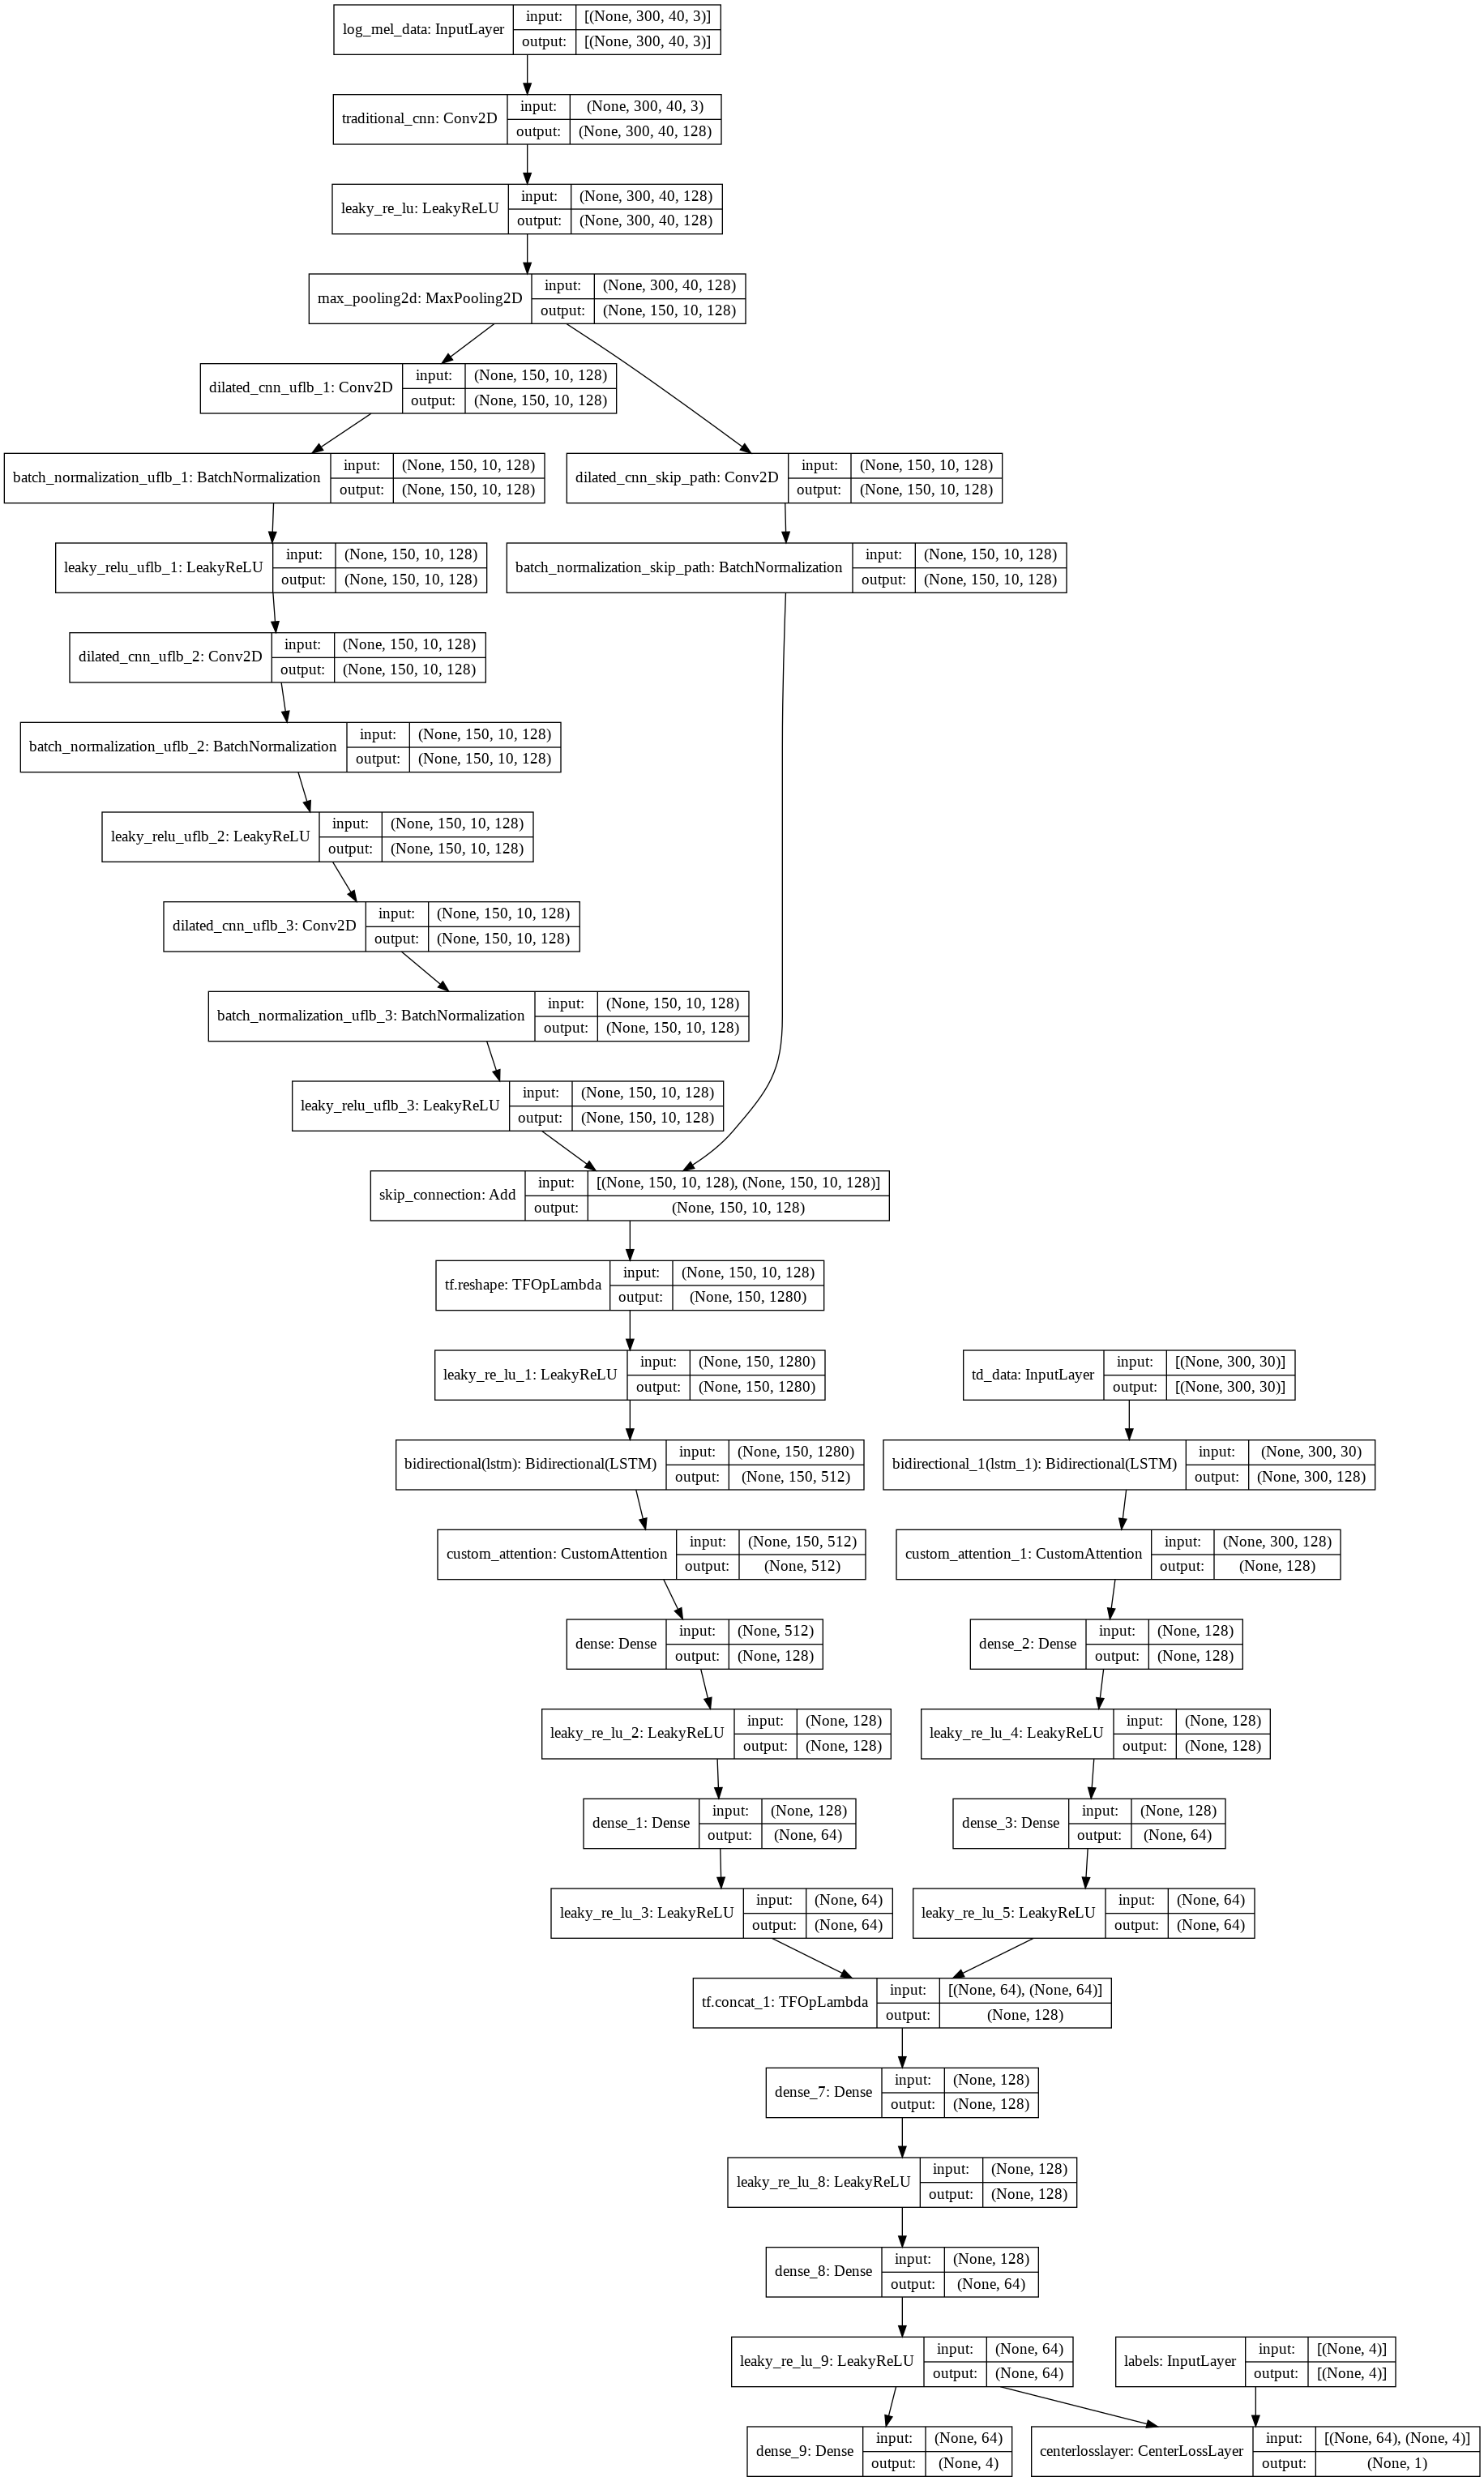

In [22]:
utils.plot_model(model, show_shapes=True)

In [23]:
print(model.summary())

Model: "adrnn_with_td_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
log_mel_data (InputLayer)       [(None, 300, 40, 3)] 0                                            
__________________________________________________________________________________________________
traditional_cnn (Conv2D)        (None, 300, 40, 128) 3584        log_mel_data[0][0]               
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 300, 40, 128) 0           traditional_cnn[0][0]            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 150, 10, 128) 0           leaky_re_lu[0][0]                
________________________________________________________________________________